 📊 Customer Churn Prediction / Müşteri Terk Etme Tahmini

In [125]:
# Gerekli kütüphaneleri içe aktar – Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap


In [65]:
# Uyarıları kapatma – Disable warnings
import warnings
warnings.filterwarnings("ignore")


In [67]:
# Veriyi oku – Read the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [69]:
# İlk 5 satıra göz at – View the first 5 rows
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [71]:
# Veri setinin genel bilgisi – General info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [73]:
# Eksik değerlerin kontrolü – Check for missing values
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [75]:
# Özet istatistikler – Summary statistics
print(df.describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [109]:
# 'TotalCharges' sütununda boşluk olanları NaN yap – Convert empty strings to NaN
df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)

# Sayısal değere çevir – Convert to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])

# NaN içeren satırları çıkar – Drop rows with missing values
df.dropna(subset=["TotalCharges"], inplace=True)

# Sayısal kolonları float yap – Convert numeric columns to float
df["TotalCharges"] = df["TotalCharges"].astype(float)

# "customerID" gereksiz, çıkar – Drop unnecessary ID column
df.drop("customerID", axis=1, inplace=True)


In [79]:
# NaN değerlerin tekrar kontrolü – Re-checking for NaNs
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [85]:
# Sınıfların oranı – Class proportions
print(df['Churn'].value_counts(normalize=True))

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


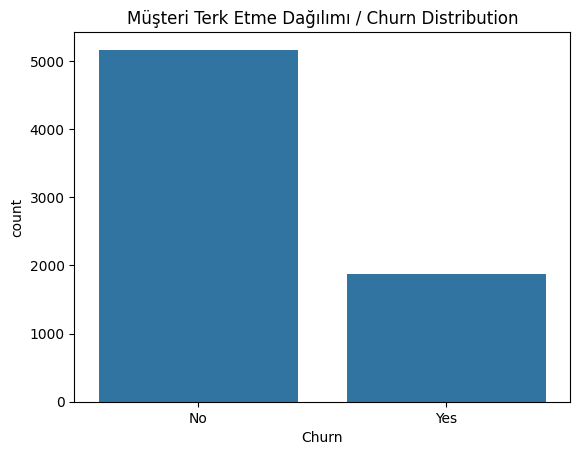

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


In [111]:
# Sınıf dağılımı – Target variable class distribution
sns.countplot(x='Churn', data=df)
plt.title("Müşteri Terk Etme Dağılımı / Churn Distribution")
plt.show()

# Oranları yazdır – Show proportions
print(df['Churn'].value_counts(normalize=True))


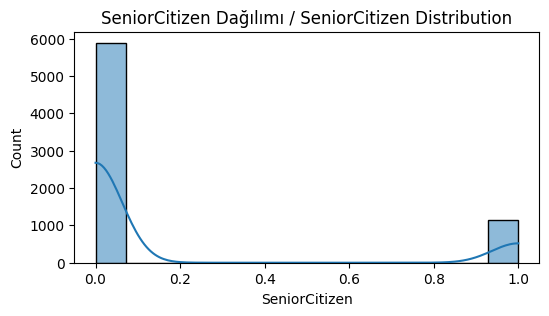

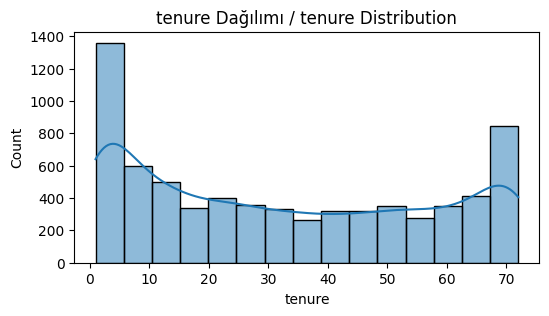

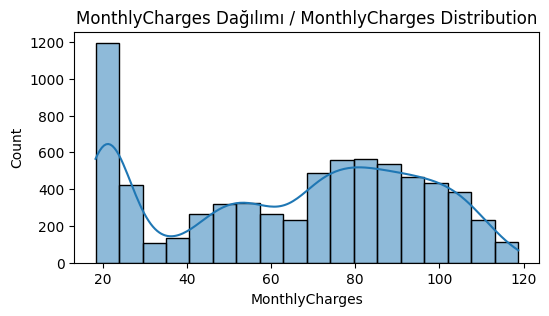

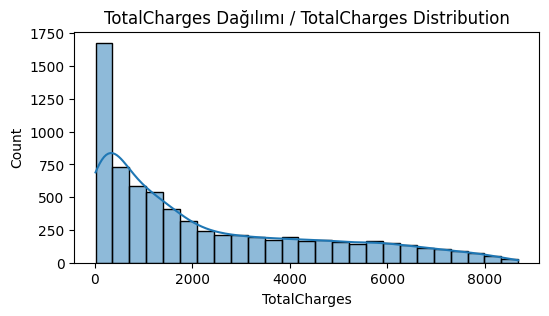

In [91]:
# Sayısal değişkenlerin dağılımı – Distribution of numerical features
for col in num_features:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} Dağılımı / {col} Distribution")
    plt.show()


In [113]:
# Tüm kategorik değişkenleri dummies ile encode et – One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Kontrol – Check encoded features
print(df_encoded.head())


   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male  \
0              0       1           29.85         29.85        False   
1              0      34           56.95       1889.50         True   
2              0       2           53.85        108.15         True   
3              0      45           42.30       1840.75         True   
4              0       2           70.70        151.65        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  MultipleLines_Yes  ...  StreamingTV_Yes  \
0                            True              False  ...            False   
1                           False              False  ...            False   
2                         

In [115]:
# Bağımlı ve bağımsız değişkenler – Define X and y
X = df_encoded.drop("Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]  # Churn: Yes -> 1, No -> 0

# Eğitim ve test verisi – Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [117]:
# Modeller – Models
log_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Eğit – Fit
log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [121]:
models = {"Logistic Regression": log_model, "Random Forest": rf_model}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Model: {name}")
    print("Doğruluk Oranı / Accuracy:", round(acc, 3))
    print(" Classification Report:\n", classification_report(y_test, y_pred))
    print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



 Model: Logistic Regression
Doğruluk Oranı / Accuracy: 0.8
 Classification Report:
               precision    recall  f1-score   support

       False       0.85      0.88      0.87      1033
        True       0.64      0.57      0.60       374

    accuracy                           0.80      1407
   macro avg       0.74      0.73      0.73      1407
weighted avg       0.79      0.80      0.80      1407

 Confusion Matrix:
 [[912 121]
 [161 213]]

 Model: Random Forest
Doğruluk Oranı / Accuracy: 0.79
 Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.89      0.86      1033
        True       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

 Confusion Matrix:
 [[917 116]
 [180 194]]


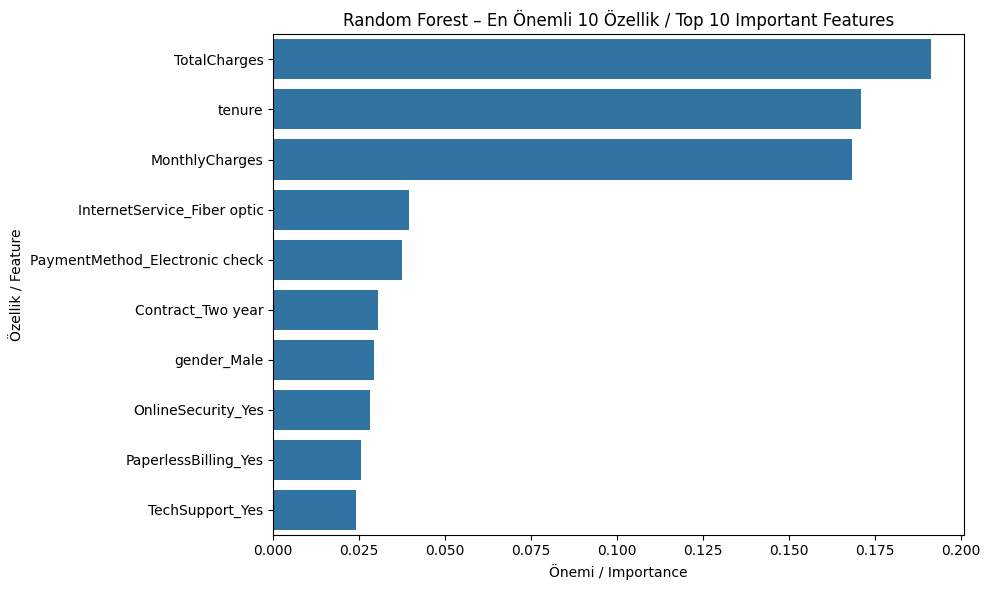

In [123]:
# Feature Importance – Özelliklerin önemini göster
importances = rf_model.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Görselleştirme – Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=forest_importances[:10], y=forest_importances[:10].index)
plt.title("Random Forest – En Önemli 10 Özellik / Top 10 Important Features")
plt.xlabel("Önemi / Importance")
plt.ylabel("Özellik / Feature")
plt.tight_layout()
plt.show()
